# Extract time series parameters from flow and use to predict extreme snowmelt

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, KFold, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_recall_curve, auc, classification_report, explained_variance_score, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt


In [2]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series


In [3]:
# setup for search grid
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


In [4]:
# build scorer function
def auc_pr_score(y_true, y_pred):
	precision, recall, _ = precision_recall_curve(y_true, y_pred)
	return auc(recall, precision)


auc_pr = make_scorer(auc_pr_score, greater_is_better=True)

N_DAYS = 30
TIME_LAG = 1

## Create rolled dataframe 

In [31]:
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean


,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id
0,0,1945-05-23,0.00,0.00,0,51.0,157010.0,35296.197180,182.0000,1945,5,413.351800,1746.0,51.0 157010.0
1,1,1945-05-24,0.00,0.00,0,51.0,157010.0,35296.197180,176.0000,1945,5,413.351800,1746.0,51.0 157010.0
2,2,1945-05-25,0.00,0.00,0,51.0,157010.0,35296.197180,164.0000,1945,5,413.351800,1746.0,51.0 157010.0
3,3,1945-05-26,0.00,0.00,0,51.0,157010.0,35296.197180,152.0000,1945,5,413.351800,1746.0,51.0 157010.0
4,4,1945-05-27,0.00,0.00,0,51.0,157010.0,35296.197180,143.0000,1945,5,413.351800,1746.0,51.0 157010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506247,1556668,1995-10-16,0.00,0.00,0,17.0,172790.0,10680.378993,211.8655,1995,10,48.634316,381.0,17.0 172790.0
1506248,1556669,1995-10-17,0.00,0.00,0,17.0,172790.0,10680.378993,209.7427,1995,10,48.634316,381.0,17.0 172790.0
1506249,1556670,1995-10-18,0.00,0.00,0,17.0,172790.0,10680.378993,212.7924,1995,10,48.634316,381.0,17.0 172790.0
1506250,1556671,1995-10-19,0.04,0.04,0,17.0,172790.0,10680.378993,215.6614,1995,10,48.634316,381.0,17.0 172790.0


In [32]:
# remove site pairs with distance > 100 km and keep only nearest site pair
all_data_clean = all_data_clean[all_data_clean['distance'] < 10000]
idx = all_data_clean.groupby('flow_site_id')['distance'].transform(min) == all_data_clean['distance']
all_data_clean = all_data_clean[idx]
all_data_clean

,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id
2205,2205,1952-11-11,0.18,0.09,0,1315.0,183760.0,325.142026,62.0000,1952,11,50.920328,218.0000,1315.0 183760.0
2209,2209,1956-10-21,0.00,0.00,0,1315.0,183760.0,325.142026,72.0000,1956,10,60.541542,252.4545,1315.0 183760.0
2213,2213,1957-04-30,0.00,-0.11,1,1315.0,183760.0,325.142026,24.0000,1957,4,27.770907,177.0000,1315.0 183760.0
2218,2218,1957-10-03,0.00,0.00,0,1315.0,183760.0,325.142026,189.0000,1957,10,91.637784,391.8382,1315.0 183760.0
2222,2222,1957-10-04,0.12,0.12,0,1315.0,183760.0,325.142026,187.0000,1957,10,91.637784,391.8382,1315.0 183760.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498865,1549286,2020-10-05,0.00,0.00,0,2053.0,126430.0,4452.589044,0.0645,2020,10,68.098947,736.0000,2053.0 126430.0
1498866,1549287,2020-10-15,0.00,0.00,0,2053.0,126430.0,4452.589044,0.4668,2020,10,68.098947,736.0000,2053.0 126430.0
1498867,1549288,2020-10-19,0.00,0.00,0,2053.0,126430.0,4452.589044,0.2470,2020,10,68.098947,736.0000,2053.0 126430.0
1498868,1549289,2020-11-01,0.00,0.00,0,2053.0,126430.0,4452.589044,0.4525,2020,11,80.551386,1014.0000,2053.0 126430.0


In [33]:

df_rolled = roll_time_series(
    all_data_clean[['date', 'site_id', 'flow', 'binary']], column_id="site_id", column_sort="date", max_timeshift=N_DAYS, min_timeshift=N_DAYS - 1, n_jobs=20)


Rolling: 100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


In [34]:
df_rolled

,date,site_id,flow,binary,id
1442217,1972-01-01,10006.0 192830.0,16.0,1,"(10006.0 192830.0, 1972-01-20)"
1442218,1972-01-02,10006.0 192830.0,16.0,1,"(10006.0 192830.0, 1972-01-20)"
1442219,1972-01-03,10006.0 192830.0,16.0,0,"(10006.0 192830.0, 1972-01-20)"
1442220,1972-01-04,10006.0 192830.0,16.0,0,"(10006.0 192830.0, 1972-01-20)"
1442221,1972-01-05,10006.0 192830.0,16.0,0,"(10006.0 192830.0, 1972-01-20)"
...,...,...,...,...,...
1862039,1984-12-27,655.0 113190.0,9.8,0,"(655.0 113190.0, 1984-12-31)"
1862040,1984-12-28,655.0 113190.0,9.6,0,"(655.0 113190.0, 1984-12-31)"
1862041,1984-12-29,655.0 113190.0,9.4,0,"(655.0 113190.0, 1984-12-31)"
1862042,1984-12-30,655.0 113190.0,9.2,0,"(655.0 113190.0, 1984-12-31)"


In [35]:
df_rolled.to_csv('../df_rolled_' + str(N_DAYS) + '_dist_unique.csv', index=False)

## Extract minimal timeseries features

In [36]:
df_rolled = pd.read_csv('../df_rolled_' + str(N_DAYS) + '_dist_unique.csv')


In [37]:
df_rolled

,date,site_id,flow,binary,id
0,1972-01-01,10006.0 192830.0,16.0,1,"('10006.0 192830.0', '1972-01-20')"
1,1972-01-02,10006.0 192830.0,16.0,1,"('10006.0 192830.0', '1972-01-20')"
2,1972-01-03,10006.0 192830.0,16.0,0,"('10006.0 192830.0', '1972-01-20')"
3,1972-01-04,10006.0 192830.0,16.0,0,"('10006.0 192830.0', '1972-01-20')"
4,1972-01-05,10006.0 192830.0,16.0,0,"('10006.0 192830.0', '1972-01-20')"
...,...,...,...,...,...
6615578,1984-12-27,655.0 113190.0,9.8,0,"('655.0 113190.0', '1984-12-31')"
6615579,1984-12-28,655.0 113190.0,9.6,0,"('655.0 113190.0', '1984-12-31')"
6615580,1984-12-29,655.0 113190.0,9.4,0,"('655.0 113190.0', '1984-12-31')"
6615581,1984-12-30,655.0 113190.0,9.2,0,"('655.0 113190.0', '1984-12-31')"


In [38]:
# extract timeseries features

X_features_all = extract_features(
	df_rolled.drop(["binary"], axis=1), column_id='id', column_sort='date', column_value="flow", 
	n_jobs=20, disable_progressbar=False, default_fc_parameters=MinimalFCParameters())


X_features_all.head()


Feature Extraction: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum
"('10006.0 192830.0', '1972-01-20')",298.0,15.0,14.900000,20.0,0.768115,0.590000,14.919786,16.0,14.0
"('10006.0 192830.0', '1972-01-21')",312.0,15.0,14.857143,21.0,0.773718,0.598639,14.877276,16.0,14.0
"('10006.0 192830.0', '1972-01-22')",310.0,15.0,14.761905,21.0,0.749906,0.562358,14.780940,16.0,14.0
"('10006.0 192830.0', '1972-01-23')",308.0,15.0,14.666667,21.0,0.712697,0.507937,14.683972,16.0,14.0
"('10006.0 192830.0', '1972-01-24')",306.0,14.0,14.571429,21.0,0.659829,0.435374,14.586360,16.0,14.0


In [39]:
X_features_all.to_csv('../df_extracted_min_' + str(N_DAYS) + '_dist_unique.csv')


## Undersample minimal timeseries feature dataset and run Random Forest model

In [40]:
X_features_all = pd.read_csv(
    '../df_extracted_min_' + str(N_DAYS) + '_dist_unique.csv')


In [41]:
import ast

X_features_all['unique_id'] = X_features_all['Unnamed: 0'].apply(ast.literal_eval)
X_features_all = X_features_all.drop('Unnamed: 0', axis=1)
X_features_all.head()


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id
0,298.0,15.0,14.900000,20.0,0.768115,0.590000,14.919786,16.0,14.0,"(10006.0 192830.0, 1972-01-20)"
1,312.0,15.0,14.857143,21.0,0.773718,0.598639,14.877276,16.0,14.0,"(10006.0 192830.0, 1972-01-21)"
2,310.0,15.0,14.761905,21.0,0.749906,0.562358,14.780940,16.0,14.0,"(10006.0 192830.0, 1972-01-22)"
3,308.0,15.0,14.666667,21.0,0.712697,0.507937,14.683972,16.0,14.0,"(10006.0 192830.0, 1972-01-23)"
4,306.0,14.0,14.571429,21.0,0.659829,0.435374,14.586360,16.0,14.0,"(10006.0 192830.0, 1972-01-24)"


In [42]:
all_data_clean = pd.read_csv('../all_data_clean.csv')

### to get the binary labels for last day of rolled time series
# all_data_clean['unique_id'] = list(zip(all_data_clean.site_id, all_data_clean.date))

### to get the binary labels for n days after end of rolled time series
all_data_clean['shifted_date'] = pd.to_datetime(all_data_clean.date) + pd.Timedelta(days=TIME_LAG)
all_data_clean['shifted_date'] = all_data_clean['shifted_date'].dt.strftime('%Y-%m-%d')
all_data_clean['unique_id'] = list(zip(all_data_clean.site_id, all_data_clean.shifted_date))
all_data_clean = all_data_clean.dropna()
all_data_clean.head()


,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id,shifted_date,unique_id
0,0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-06-02,"(51.0 157010.0, 1945-06-02)"
1,1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-06-03,"(51.0 157010.0, 1945-06-03)"
2,2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-06-04,"(51.0 157010.0, 1945-06-04)"
3,3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-06-05,"(51.0 157010.0, 1945-06-05)"
4,4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-06-06,"(51.0 157010.0, 1945-06-06)"


In [43]:
X_features_all = pd.merge(X_features_all, all_data_clean[[
                          'binary', 'unique_id']], how='left', on='unique_id')
X_features_all = X_features_all.set_index(
    X_features_all['unique_id'], drop=True)
X_features_all = X_features_all.dropna()
X_features_all.head()

,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id,binary
unique_id,,,,,,,,,,,
"(10006.0 192830.0, 1972-01-20)",298.0,15.0,14.900000,20.0,0.768115,0.590000,14.919786,16.0,14.0,"(10006.0 192830.0, 1972-01-20)",0.0
"(10006.0 192830.0, 1972-01-21)",312.0,15.0,14.857143,21.0,0.773718,0.598639,14.877276,16.0,14.0,"(10006.0 192830.0, 1972-01-21)",0.0
"(10006.0 192830.0, 1972-01-22)",310.0,15.0,14.761905,21.0,0.749906,0.562358,14.780940,16.0,14.0,"(10006.0 192830.0, 1972-01-22)",0.0
"(10006.0 192830.0, 1972-01-23)",308.0,15.0,14.666667,21.0,0.712697,0.507937,14.683972,16.0,14.0,"(10006.0 192830.0, 1972-01-23)",0.0
"(10006.0 192830.0, 1972-01-24)",306.0,14.0,14.571429,21.0,0.659829,0.435374,14.586360,16.0,14.0,"(10006.0 192830.0, 1972-01-24)",0.0


In [44]:
y1 = X_features_all['binary']
Counter(y1)


Counter({0.0: 281503, 1.0: 14842})

In [45]:
# undersample to balance classes
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection

# undersample = RandomUnderSampler(sampling_strategy='majority')
# undersample = RandomUnderSampler(sampling_strategy=0.5)
undersample = NearMiss(version=3, n_neighbors=3)
# undersample = OneSidedSelection(n_jobs=20)
X_under, y_under = undersample.fit_resample(
    X_features_all.drop(columns=['binary', 'unique_id']), y1)


In [46]:
X_under.index = X_features_all.index[undersample.sample_indices_]
Counter(y_under)


Counter({0.0: 14842, 1.0: 14842})

In [47]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_under, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

         0.0       0.72      0.87      0.79      5977
         1.0       0.83      0.65      0.73      5897

    accuracy                           0.76     11874
   macro avg       0.77      0.76      0.76     11874
weighted avg       0.77      0.76      0.76     11874



0.8283840694890061

In [48]:
df_rolled['unique_id'] = df_rolled['id'].apply(ast.literal_eval)
df_rolled.unique_id

0          (10006.0 192830.0, 1972-01-20)
1          (10006.0 192830.0, 1972-01-20)
2          (10006.0 192830.0, 1972-01-20)
3          (10006.0 192830.0, 1972-01-20)
4          (10006.0 192830.0, 1972-01-20)
                        ...              
6615578      (655.0 113190.0, 1984-12-31)
6615579      (655.0 113190.0, 1984-12-31)
6615580      (655.0 113190.0, 1984-12-31)
6615581      (655.0 113190.0, 1984-12-31)
6615582      (655.0 113190.0, 1984-12-31)
Name: unique_id, Length: 6615583, dtype: object

In [49]:
X_under.head()

,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum
unique_id,,,,,,,,,
"(2012.0 183760.0, 1995-06-06)",13991.5588,778.3509,666.264705,21.0,416.007638,173062.354894,785.475023,1201.5210,32.5947
"(2012.0 183760.0, 1979-06-01)",10787.3408,375.2478,513.682895,21.0,412.013280,169754.943265,658.502134,1137.7921,46.4681
"(2012.0 183760.0, 1979-05-31)",9802.2308,300.0142,466.772895,21.0,406.883705,165554.349340,619.218285,1137.7921,42.4458
"(2012.0 183760.0, 1978-05-29)",8487.7455,190.8346,404.178357,21.0,376.882964,142040.768196,552.630901,1060.0002,27.3195
"(2012.0 183760.0, 1978-05-27)",7168.3780,107.0141,341.351333,21.0,378.821491,143505.722252,509.927892,1060.0002,24.3723


In [50]:
X_under_all = df_rolled[df_rolled.unique_id.isin(X_under.index)]
X_under_all


,date,site_id,flow,binary,id,unique_id
2372,1972-04-22,10006.0 192830.0,11.0,0,"('10006.0 192830.0', '1972-05-12')","(10006.0 192830.0, 1972-05-12)"
2373,1972-04-23,10006.0 192830.0,11.0,0,"('10006.0 192830.0', '1972-05-12')","(10006.0 192830.0, 1972-05-12)"
2374,1972-04-24,10006.0 192830.0,11.0,0,"('10006.0 192830.0', '1972-05-12')","(10006.0 192830.0, 1972-05-12)"
2375,1972-04-25,10006.0 192830.0,11.0,0,"('10006.0 192830.0', '1972-05-12')","(10006.0 192830.0, 1972-05-12)"
2376,1972-04-26,10006.0 192830.0,11.0,0,"('10006.0 192830.0', '1972-05-12')","(10006.0 192830.0, 1972-05-12)"
...,...,...,...,...,...,...
6615368,1984-12-13,655.0 113190.0,15.0,0,"('655.0 113190.0', '1984-12-17')","(655.0 113190.0, 1984-12-17)"
6615369,1984-12-14,655.0 113190.0,14.5,0,"('655.0 113190.0', '1984-12-17')","(655.0 113190.0, 1984-12-17)"
6615370,1984-12-15,655.0 113190.0,14.0,0,"('655.0 113190.0', '1984-12-17')","(655.0 113190.0, 1984-12-17)"
6615371,1984-12-16,655.0 113190.0,13.5,0,"('655.0 113190.0', '1984-12-17')","(655.0 113190.0, 1984-12-17)"


In [51]:
X_under_all.to_csv('../df_undersampled_nearmiss_' +
                    str(N_DAYS) + '_dist_unique_' + str(TIME_LAG) + '.csv', index=False)


## Extract complete set of timeseries features on undersampled dataframe

In [52]:
X_under_all = pd.read_csv(
    '../df_undersampled_nearmiss_' + str(N_DAYS) + '_dist_unique_' + str(TIME_LAG) + '.csv')


In [53]:
# Split dataframe in two to avoid problems with memory

X_under_all.sort_values(by=['unique_id'])

X_under_1 = X_under_all[:len(X_under_all)//2]
X_under_2 = X_under_all[len(X_under_all)//2:]


In [54]:
X_features_under_1 = extract_features(
	X_under_1.drop(["binary", "id"], axis=1), column_id='unique_id', column_sort='date', column_value="flow",
	n_jobs=10, disable_progressbar=False)


Feature Extraction: 100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


In [55]:
X_features_under_1.to_csv(
    '../df_extracted_1_nearmiss_' + str(N_DAYS) + '_dist_unique_' + str(TIME_LAG) + '.csv')


In [56]:
X_features_under_2 = extract_features(
	X_under_2.drop(["binary", "id"], axis=1), column_id='unique_id', column_sort='date', column_value="flow",
	n_jobs=10, disable_progressbar=False)


Feature Extraction: 100%|██████████| 50/50 [01:40<00:00,  2.02s/it]


In [57]:
X_features_under_2.to_csv(
    '../df_extracted_2_nearmiss_' + str(N_DAYS) + '_dist_unique_' + str(TIME_LAG) + '.csv')


In [58]:
X_features_under_1 = pd.read_csv(
    '../df_extracted_1_nearmiss_' + str(N_DAYS) + '_dist_unique_' + str(TIME_LAG) + '.csv')
X_features_under_2 = pd.read_csv(
    '../df_extracted_2_nearmiss_' + str(N_DAYS) + '_dist_unique_' + str(TIME_LAG) + '.csv')

X_features_under_all = pd.concat([X_features_under_1, X_features_under_2])
X_features_under_all.shape


(29684, 788)

In [59]:
X_features_under_all.to_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '_dist_unique_' + str(TIME_LAG) + '.csv', index=False)


## Build Random Forest model with complete set of extracted timeseries parameters

In [5]:
import ast

X_features_under_all = pd.read_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '_dist_unique_' + str(TIME_LAG) + '.csv')

all_data_clean = pd.read_csv('../all_data_clean.csv')

### to get the binary labels for last day of rolled time series
# all_data_clean['unique_id'] = list(zip(all_data_clean.site_id, all_data_clean.date))

### to get the binary labels for n days after end of rolled time series
all_data_clean['shifted_date'] = pd.to_datetime(
    all_data_clean.date) + pd.Timedelta(days=TIME_LAG)
all_data_clean['shifted_date'] = all_data_clean['shifted_date'].dt.strftime(
    '%Y-%m-%d')
all_data_clean['unique_id'] = list(
    zip(all_data_clean.site_id, all_data_clean.shifted_date))
all_data_clean = all_data_clean.dropna()
all_data_clean.head()




,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id,shifted_date,unique_id
0,0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-05-24,"(51.0 157010.0, 1945-05-24)"
1,1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-05-25,"(51.0 157010.0, 1945-05-25)"
2,2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-05-26,"(51.0 157010.0, 1945-05-26)"
3,3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-05-27,"(51.0 157010.0, 1945-05-27)"
4,4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0,1945,5,413.3518,1746.0,51.0 157010.0,1945-05-28,"(51.0 157010.0, 1945-05-28)"


In [6]:
X_features_under_all['unique_id'] = X_features_under_all['Unnamed: 0'].apply(
    ast.literal_eval)


In [7]:
X_features_under_all = pd.merge(X_features_under_all, all_data_clean[[
    'binary', 'year', 'unique_id']], how='left', on='unique_id')
X_features_under_all = X_features_under_all.set_index(
    X_features_under_all['unique_id'], drop=True)
y_under = X_features_under_all['binary']
X_features_under_filtered = X_features_under_all.dropna(axis=1)
X_features_under_filtered = X_features_under_filtered.drop(
    columns=['unique_id', 'Unnamed: 0', 'binary'])
X_features_under_filtered.head()


,flow__variance_larger_than_standard_deviation,flow__has_duplicate_max,flow__has_duplicate_min,flow__has_duplicate,flow__sum_values,flow__abs_energy,flow__median,flow__mean,flow__length,flow__standard_deviation,...,flow__ratio_beyond_r_sigma__r_10,flow__count_above__t_0,flow__count_below__t_0,flow__lempel_ziv_complexity__bins_2,flow__lempel_ziv_complexity__bins_3,flow__lempel_ziv_complexity__bins_5,flow__lempel_ziv_complexity__bins_10,flow__lempel_ziv_complexity__bins_100,year,month
unique_id,,,,,,,,,,,,,,,,,,,,,
"(10006.0 192830.0, 1972-02-18)",0.0,1.0,0.0,1.0,397.0,5107.0,13.0,12.806452,31.0,0.858331,...,0.0,1.0,0.0,0.258065,0.354839,0.419355,0.419355,0.419355,1972,2
"(10006.0 192830.0, 1972-02-23)",0.0,1.0,1.0,1.0,382.0,4732.0,12.0,12.322581,31.0,0.893962,...,0.0,1.0,0.0,0.290323,0.387097,0.419355,0.419355,0.419355,1972,2
"(10006.0 192830.0, 1972-05-03)",0.0,0.0,1.0,1.0,339.0,3725.0,11.0,10.935484,31.0,0.759265,...,0.0,1.0,0.0,0.322581,0.354839,0.387097,0.387097,0.387097,1972,5
"(10006.0 192830.0, 1972-05-04)",1.0,0.0,1.0,1.0,347.0,3949.0,11.0,11.193548,31.0,1.446227,...,0.0,1.0,0.0,0.290323,0.322581,0.354839,0.387097,0.387097,1972,5
"(10006.0 192830.0, 1972-05-11)",1.0,0.0,1.0,1.0,444.0,7262.0,11.0,14.322581,31.0,5.396457,...,0.0,1.0,0.0,0.322581,0.387097,0.387097,0.419355,0.419355,1972,5


In [87]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_features_under_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.80      0.89      0.84      5826
           1       0.88      0.79      0.83      6041

    accuracy                           0.84     11867
   macro avg       0.84      0.84      0.84     11867
weighted avg       0.84      0.84      0.84     11867



0.8881794034944022

In [66]:
# split into train and test sets by date
X_filtered_sorted = X_features_under_filtered.sort_index(key=lambda d: d.map(lambda x: x[1]))
X_filtered_train = X_filtered_sorted.iloc[:len(X_filtered_sorted)//10*6]
X_filtered_test = X_filtered_sorted.iloc[len(X_filtered_sorted)//10*6:]
y_train = y_under.iloc[:len(X_filtered_sorted)//10*6]
y_test = y_under.iloc[len(X_filtered_sorted)//10*6:]

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.55      0.25      0.34      6627
           1       0.44      0.75      0.55      5243

    accuracy                           0.47     11870
   macro avg       0.50      0.50      0.45     11870
weighted avg       0.50      0.47      0.44     11870



0.6487191218987471

In [8]:
# split into training and test sets by site
indx = X_features_under_filtered.index.unique()
sites = [x[0] for x in indx]
sites = list(set(sites))
sites_test = sites[:len(sites)//10*6]
sites_train = sites[len(sites)//10*6:]
idx_train = [x for x in indx if x[0] in sites_train]
idx_test = [x for x in indx if x[0] in sites_test]
X_filtered_train = X_features_under_filtered[X_features_under_filtered.index.isin(idx_train)]
X_filtered_test = X_features_under_filtered[X_features_under_filtered.index.isin(idx_test)]
y_train = y_under[y_under.index.isin(idx_train)]
y_test = y_under[y_under.index.isin(idx_test)]

classifier_filtered = RandomForestClassifier(
    n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.77      0.91      0.83     10076
           1       0.89      0.72      0.80     10116

    accuracy                           0.82     20192
   macro avg       0.83      0.82      0.82     20192
weighted avg       0.83      0.82      0.82     20192



0.8767554065255054

In [9]:
# time series split
X_filtered_sorted = X_features_under_filtered.sort_index(
    key=lambda d: d.map(lambda x: x[1]))
tscv = TimeSeriesSplit(n_splits=10)

index_output = tscv.split(X_filtered_sorted)

clf = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1, max_depth=1, n_estimators=500, max_features=5)
cv_results = cross_validate(
    clf,
    X_filtered_sorted,
    y_under,
    cv=index_output,
    scoring=auc_pr,
)

print(np.mean(cv_results['test_score']))


0.6815483994376784


In [46]:
# try automatic feature selection

sel = SelectFromModel(RandomForestClassifier(n_jobs=-1, random_state=42))
sel.fit(X_filtered_train, y_train)
selected_feat = X_filtered_train.columns[(sel.get_support())]

In [47]:
X_selected = X_features_under_filtered[selected_feat]
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_selected, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.82      0.90      0.86      6744
           1       0.89      0.81      0.85      6770

    accuracy                           0.85     13514
   macro avg       0.86      0.85      0.85     13514
weighted avg       0.86      0.85      0.85     13514



0.896958843663505

<AxesSubplot:>

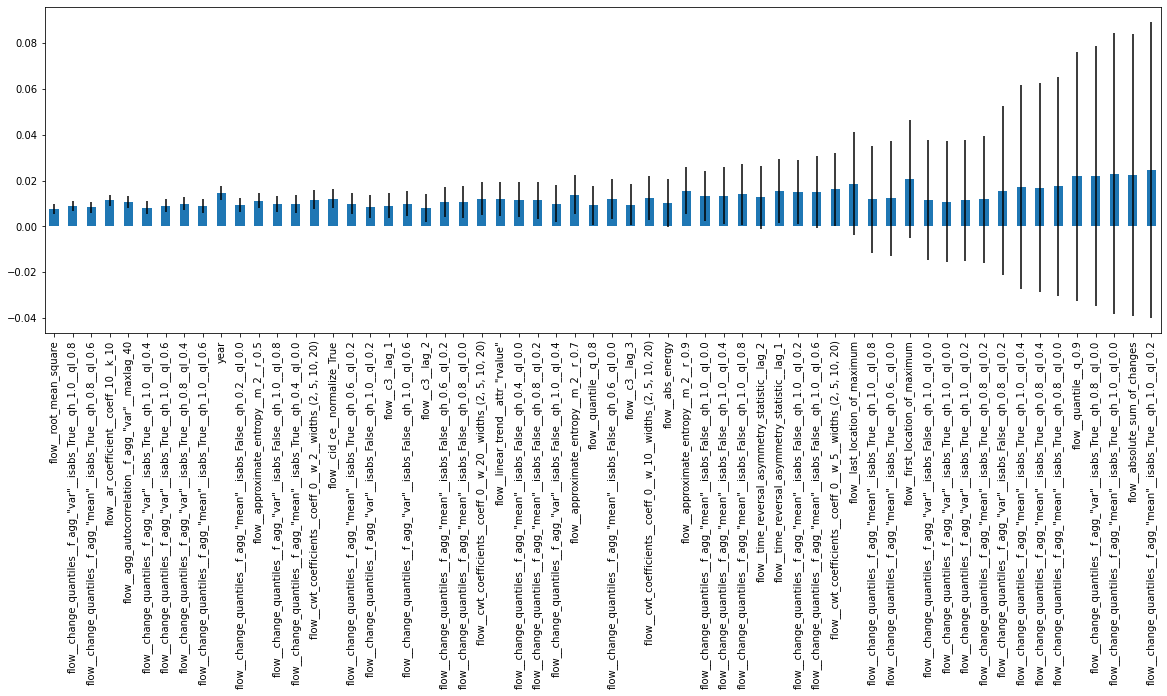

In [49]:
# features with lowest standard deviation

importances = classifier_filtered.feature_importances_
forest_importances = pd.Series(
    importances, index=X_selected.columns)

std = np.std(
    [tree.feature_importances_ for tree in classifier_filtered.estimators_], axis=0)
lowest_std_indices = pd.Series(
    std, index=X_selected.columns).nsmallest(60).index
lowest_std = pd.Series(
    std, index=X_selected.columns).nsmallest(60)

lowest_features = forest_importances[lowest_std_indices]

plt.figure(figsize=(20, 6))
lowest_features.plot.bar(yerr=lowest_std)


<AxesSubplot:ylabel='Mean Feature Importance'>

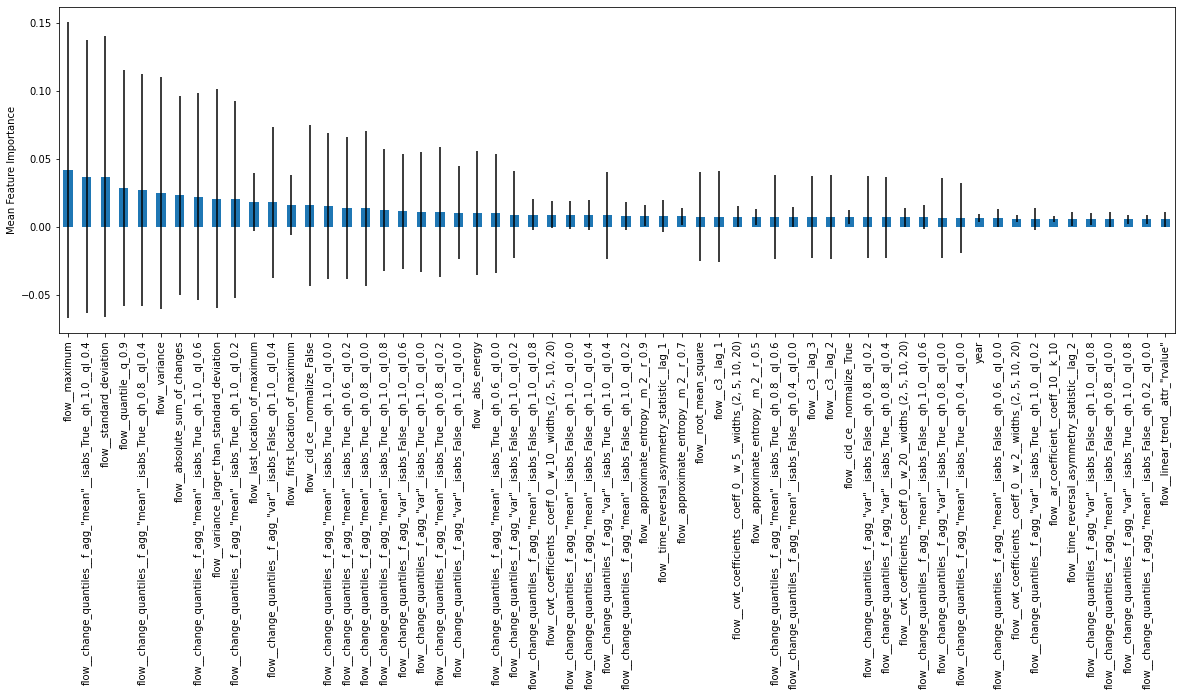

In [52]:
# features with highest importance
importances = classifier_filtered.feature_importances_
forest_importances = pd.Series(
    importances, index=X_features_under_filtered.columns)
main_features = forest_importances.nlargest(60)
main_features_indices = pd.Series(importances).nlargest(60).index

std = np.std(
    [tree.feature_importances_ for tree in classifier_filtered.estimators_], axis=0)
main_std = std[main_features_indices]

plt.figure(figsize=(20, 6))
plt.ylabel('Mean Feature Importance')
main_features.plot.bar(yerr=main_std)


## Select relevant features and run model only on those

In [92]:
# select relevant features
X_filtered = select_features(X_features_under_filtered, y_under, n_jobs=20)

X_filtered.head()


,flow__sum_values,"flow__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2",...,"flow__agg_autocorrelation__f_agg_""median""__maxlag_40",flow__ratio_beyond_r_sigma__r_3,flow__number_crossing_m__m_0,flow__ratio_beyond_r_sigma__r_2.5,flow__ratio_beyond_r_sigma__r_5,flow__ratio_beyond_r_sigma__r_0.5,flow__symmetry_looking__r_0.15000000000000002,flow__symmetry_looking__r_0.1,flow__last_location_of_minimum,flow__approximate_entropy__m_2__r_0.3
unique_id,,,,,,,,,,,,,,,,,,,,,
"(10006.0 192830.0, 1972-02-18)",397.0,0.064209,0.064209,0.068966,0.064209,0.045351,0.047619,0.045351,-0.047619,0.000000,...,-0.534507,0.000000,0.0,0.000000,0.0,0.677419,1.0,1.0,1.000000,0.220197
"(10006.0 192830.0, 1972-05-02)",335.0,0.128889,0.035665,0.037037,0.035665,0.035665,0.037037,0.035665,0.037037,0.035665,...,-0.307555,0.000000,0.0,0.000000,0.0,0.322581,1.0,1.0,0.258065,0.251804
"(10006.0 192830.0, 1972-05-03)",339.0,0.248889,0.036982,0.038462,0.036982,0.036982,0.038462,0.036982,0.038462,0.036982,...,-0.024828,0.032258,0.0,0.032258,0.0,0.322581,1.0,1.0,0.225806,0.249330
"(10006.0 192830.0, 1972-05-10)",430.0,1.445556,0.817708,0.375000,0.873264,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.291109,0.000000,0.0,0.000000,0.0,0.903226,0.0,0.0,0.709677,0.105235
"(10006.0 192830.0, 1972-05-11)",444.0,1.448889,1.659722,0.583333,1.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.352115,0.000000,0.0,0.000000,0.0,0.903226,0.0,0.0,0.677419,0.112104


In [93]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86      7029
           1       0.89      0.80      0.84      6824

    accuracy                           0.85     13853
   macro avg       0.86      0.85      0.85     13853
weighted avg       0.86      0.85      0.85     13853



0.8960711175942538

In [94]:
# time series split
tscv = TimeSeriesSplit(n_splits=10)
X_filtered_sorted = X_filtered.sort_index(key=lambda d: d.map(lambda x: x[1]))
index_output = tscv.split(X_filtered_sorted)

clf = RandomForestClassifier(
    random_state=42, verbose=0, n_jobs=-1, max_depth=1)
cv_results = cross_validate(
    clf,
    X_filtered_sorted,
    y_under,
    cv=index_output,
    scoring=auc_pr,
)

print(np.mean(cv_results['test_score']))


0.6874447647204438


In [48]:
# try with grid search


kf = KFold()
index_output = kf.split(X_features_under_filtered)

clf = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1)

param_distributions = {
	'n_estimators': loguniform_int(2, 256),
	'criterion': ['gini', 'entropy'],
	'min_samples_split': loguniform_int(2, 256),
	'min_samples_leaf': loguniform_int(1, 100),
	'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 5}, {0: 1, 1: 2}, {0: 1, 1: 1}],
}

model_random_search = RandomizedSearchCV(
    clf, param_distributions=param_distributions, n_iter=200, n_jobs=-1, scoring=auc_pr,
    cv=index_output, verbose=1,
)
model_random_search.fit(X_features_under_filtered, y_under)
n_estimators = model_random_search.best_params_['n_estimators']
criterion = model_random_search.best_params_['criterion']
min_samples_split = model_random_search.best_params_['min_samples_split']
min_samples_leaf = model_random_search.best_params_['min_samples_leaf']
class_weight = model_random_search.best_params_['class_weight']
model_random_search.best_params_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
# random forest - cross validation with new parameters

new_regressor = RandomForestClassifier(
    random_state=42,
   	n_jobs=-1, verbose=0,
   	criterion=criterion,
   	min_samples_leaf=min_samples_leaf,
   	min_samples_split=min_samples_split,
   	n_estimators=n_estimators
)
index_output = kf.split(X_filtered)

cv_results = cross_validate(
    new_regressor,
    X_filtered,
    y_under,
    cv=index_output,
    scoring=auc_pr,
)

print(np.mean(cv_results['test_score']))


### Try XGBoost

In [34]:
# split into training and test sets by site
from xgboost import XGBClassifier

indx = X_features_under_filtered.index.unique()
sites = [x[0] for x in indx]
sites = list(set(sites))
sites_test = sites[:len(sites)//10*6]
sites_train = sites[len(sites)//10*6:]
idx_train = [x for x in indx if x[0] in sites_train]
idx_test = [x for x in indx if x[0] in sites_test]
X_filtered_train = X_features_under_filtered[X_features_under_filtered.index.isin(
    idx_train)]
X_filtered_test = X_features_under_filtered[X_features_under_filtered.index.isin(
    idx_test)]
y_train = y_under[y_under.index.isin(idx_train)]
y_test = y_under[y_under.index.isin(idx_test)]

params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators': 100,
   	'max_leaves': 5,
}

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_filtered_train, y_train)
print(classification_report(y_test, xgb_clf.predict(X_filtered_test)))
auc_pr_score(y_test, xgb_clf.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.76      0.81      0.78      9194
           1       0.81      0.75      0.78      9757

    accuracy                           0.78     18951
   macro avg       0.78      0.78      0.78     18951
weighted avg       0.78      0.78      0.78     18951



0.8453797496013254

In [33]:
# split into train and test sets by date
X_filtered_sorted = X_features_under_filtered.sort_index(
    key=lambda d: d.map(lambda x: x[1]))
X_filtered_train = X_filtered_sorted.iloc[:len(X_filtered_sorted)//10*6]
X_filtered_test = X_filtered_sorted.iloc[len(X_filtered_sorted)//10*6:]
y_train = y_under.iloc[:len(X_filtered_sorted)//10*6]
y_test = y_under.iloc[len(X_filtered_sorted)//10*6:]

params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'alpha': 10,
    'learning_rate': 1,
    'n_estimators': 100,
	'max_leaves': 5,
}

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_filtered_train, y_train)
auc_pr_score(y_test, xgb_clf.predict(X_filtered_test))


0.719274879763226

## Predict snow diff using complete timeseries parameters

In [ ]:
import ast
X_features_under_all = pd.read_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '.csv')
all_data_clean = pd.read_csv('../all_data_clean.csv')

### to get the binary labels for last day of rolled time series
# all_data_clean['unique_id'] = list(zip(all_data_clean.site_id, all_data_clean.date))

### to get the binary labels for n days after end of rolled time series
all_data_clean['shifted_date'] = pd.to_datetime(
    all_data_clean.date) + pd.Timedelta(days=TIME_LAG)
all_data_clean['shifted_date'] = all_data_clean['shifted_date'].dt.strftime(
    '%Y-%m-%d')
all_data_clean['unique_id'] = list(
    zip(all_data_clean.site_id, all_data_clean.shifted_date))
all_data_clean = all_data_clean.dropna()
all_data_clean.head()

X_features_under_all['unique_id'] = X_features_under_all['Unnamed: 0'].apply(
    ast.literal_eval)
X_features_under_all = pd.merge(X_features_under_all, all_data_clean[[
    'depth_diff', 'unique_id']], how='left', on='unique_id')
X_features_under_all = X_features_under_all.dropna()
X_features_under_all = X_features_under_all.set_index(
    X_features_under_all['unique_id'], drop=True)

y_under = X_features_under_all['depth_diff']
X_features_under_filtered = X_features_under_all.dropna(axis=1)
X_features_under_filtered = X_features_under_filtered.drop(
    columns=['unique_id', 'Unnamed: 0', 'depth_diff'])
X_features_under_filtered.head()




In [ ]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_features_under_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestRegressor(verbose=1, n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)


In [ ]:
y_pred = classifier_filtered.predict(X_filtered_test)
print('Explained variance score: {0}, MSE: {1}, R2: {2}'.format(explained_variance_score(y_test, y_pred),
                                                                mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)))


## Exploration of most meaningful parameters

In [28]:

scaler = StandardScaler().fit_transform(X_selected)
data_standardized = pd.DataFrame(
    scaler, columns=X_selected.columns)
pca = PCA(random_state=42, n_components=5)
pca.fit(data_standardized)
print(pca.explained_variance_ratio_)


[0.323825   0.11732946 0.08438674 0.05942375 0.04554057]


Text(0, 0.5, '2nd PC')

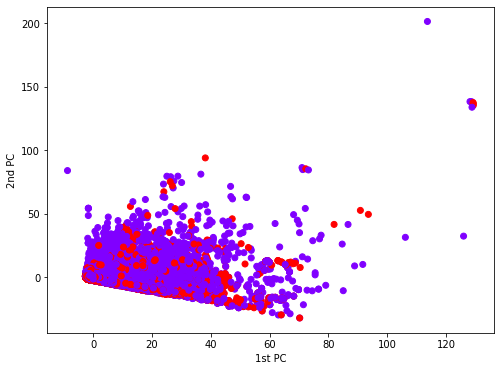

In [29]:
x_pca = pca.transform(data_standardized)

plt.figure(figsize=(8, 6))
plt.scatter(x=x_pca[:, 0], y=x_pca[:, 1],
            c=y_under, cmap='rainbow')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
